In [1]:
include("sensor.jl") # To retrieve Sensor Positions
include("./doa/cbf.jl") # Conventional Beamformer
include("./doa/dbf_freeform.jl") # Differential Beamformer (coordinate-free) 
include("./doa/music.jl") # MUSIC

include("./utils/preprocess.jl")

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [2]:
using WAV
# new_sig, sample_rate = wavread("./signal_generator/270deg_1kHz_tone_sr32kHz.wav");
# new_sig, sample_rate = wavread("./signal_generator/1000hz_circle.wav");
new_sig, sample_rate = wavread("./signal_generator/50hz_circle.wav");

In [3]:
freq = 50;            # Frequency of Interest (in Hz)
c0 = 343;             # Speed of Medium (in m/s)
NFFT = 2^8; #2^11;
noverlap = Int(NFFT * (3 // 4));

In [4]:
include("./doa/cbf.jl")
include("./doa/dbf_freeform.jl")

function filter_freq_per_ch(new_sig)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate, NFFT, noverlap);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

new_S = filter_freq_per_ch(new_sig);

In [15]:
using Statistics
#=
Prepate for TDoA
=#
corr_samples = 64;
max_snapshots = div(size(new_S, 2), corr_samples);
t_doa = 1:max_snapshots;
az = [];
P_cbfs = [];
P_dbfs = [];

doas_cbfs = [];
doas_dbfs = [];
doas_mdbfs = [];

order = 1;
dbf_filters = [];

@time for t in t_doa
    start = (t-1) * corr_samples + 1;
    end_t = t * corr_samples;
    Rx = cov(new_S[:, start:end_t], dims=2);

    P_cbf, az_list = cbf(Rx, sensors, freq, c0);
    P_dbf, az_list, ___, dbf_filter = dbf_coFree(Rx, sensors, order, freq, c0);
    # P_mdbf, az_list = mdbf(Rx, sensors, order, freq, c0, wng_pow);

    __, az_cbf = predict_az(P_cbf, az_list);
    __, az_dbf = predict_az(P_dbf, az_list);
    # __, az_mdbf = predict_az(P_mdbfs, az_list);

    push!(doas_cbfs, az_cbf)
    push!(doas_dbfs, az_dbf)
    # push!(doas_mdbfs, az_mdbf)
    push!(P_cbfs, P_cbf)
    push!(P_dbfs, P_dbf)
    # push!(P_mdbfs, P_mdbf)
    if t == 1
        append!(az, az_list)
        append!(dbf_filter, dbf_filters)
    end
end

P_cbfs = mapreduce(permutedims, vcat, P_cbfs);
P_cbfs = P_cbfs';

P_dbfs = mapreduce(permutedims, vcat, P_dbfs);
P_dbfs = P_dbfs';



weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3


weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1

weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1

weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1

weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
weighting vector: Rational{Int64}[1//2, 0//1, 1//2] has sum 1//1
ψ has rank 3
  1.565082 seconds (1.18 M allocations: 100.207 MiB, 40.63% gc time, 35.69% compilation time: 66% of which was recompilation)


In [6]:
include("./doa/mdbf.jl")
wng_pow = db2pow(0);
P_mdbfs = [];
doas_mdbfs = [];
mdbf_order = 3;

for t in t_doa
    start = (t-1) * corr_samples + 1;
    end_t = t * corr_samples;
    Rx = cov(new_S[:, start:end_t], dims=2);

    P_mdbf, az_list = mdbf(Rx, sensors, mdbf_order, freq, c0, wng_pow);
    __, az_mdbf = predict_az(P_mdbf, az_list);
    push!(doas_mdbfs, az_mdbf)
    push!(P_mdbfs, P_mdbf)

end

P_mdbfs = mapreduce(permutedims, vcat, P_mdbfs);
P_mdbfs = P_mdbfs';

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


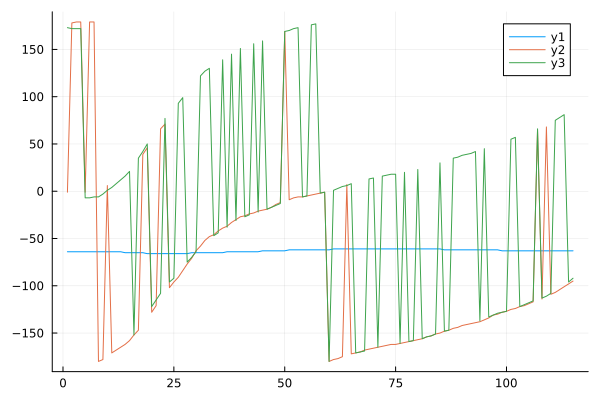

In [7]:
using Plots
plot(doas_cbfs)
plot!(doas_dbfs)
plot!(doas_mdbfs)

(361, 115)
  0.745682 seconds (1.11 M allocations: 63.656 MiB, 4.72% gc time, 99.24% compilation time: 10% of which was recompilation)

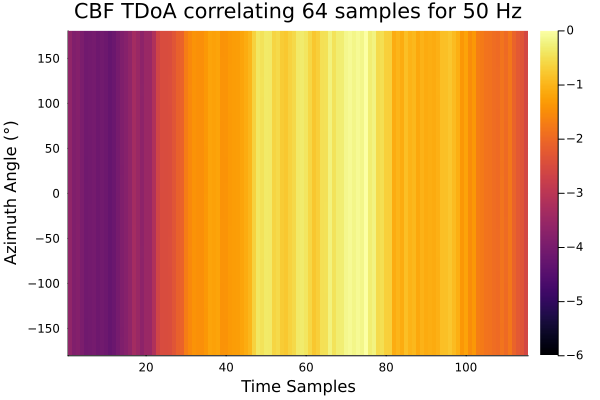

In [8]:
using Plots
using DSP.Util: pow2db
P_cbfs_db = pow2db.(P_cbfs);
P_cbfs_db .-= maximum(P_cbfs_db);
println(size(P_cbfs_db))
@time p = plot(t_doa, az, P_cbfs_db, st=:heatmap,
     clims=(-6.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="CBF TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)

In [9]:
function trace_max_power(P_bfs, az)
    az_maxes = [];
    for P_bf in eachcol(P_bfs)
        (P_max, max_idx) = findmax(P_bf)
        push!(az_maxes, az[max_idx])
        # println("Degree of max power: $(az[max_idx])")
    end
    return az_maxes
end

az_cbf_maxes = trace_max_power(P_cbfs, az);
az_dbf_maxes = trace_max_power(P_dbfs, az);

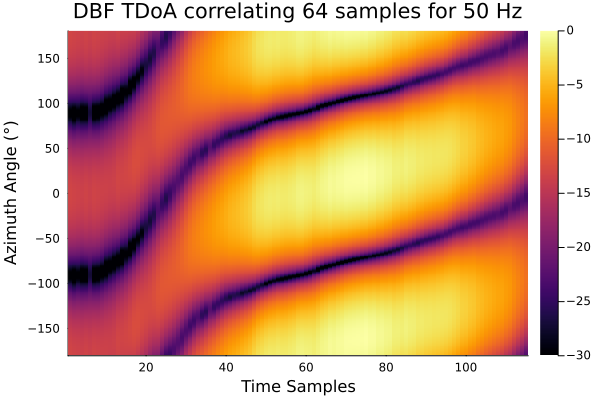

(361, 115)
  0.001696 seconds (1.36 k allocations: 442.242 KiB)


In [11]:
P_dbfs_db = pow2db.(P_dbfs);
P_dbfs_db .-= maximum(P_dbfs_db);
println(size(P_dbfs_db))
@time p = plot(t_doa, az, P_dbfs_db, st=:heatmap,
     clims=(-30.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="DBF TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)

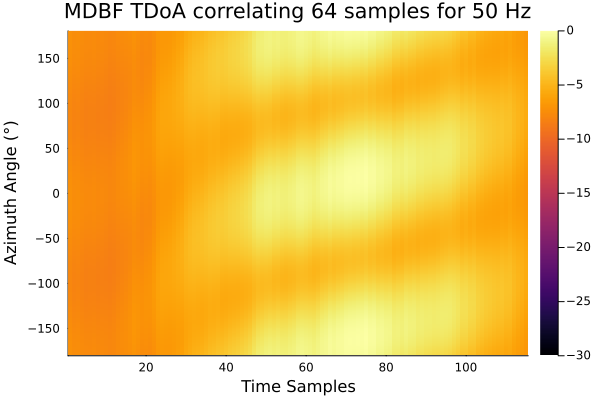

(361, 115)
  0.001609 seconds (1.36 k allocations: 442.242 KiB)


In [12]:
P_mdbfs_db = pow2db.(P_mdbfs);
P_mdbfs_db .-= maximum(P_mdbfs_db);
println(size(P_mdbfs_db))
@time p = plot(t_doa, az, P_mdbfs_db, st=:heatmap,
     clims=(-30.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="MDBF TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)

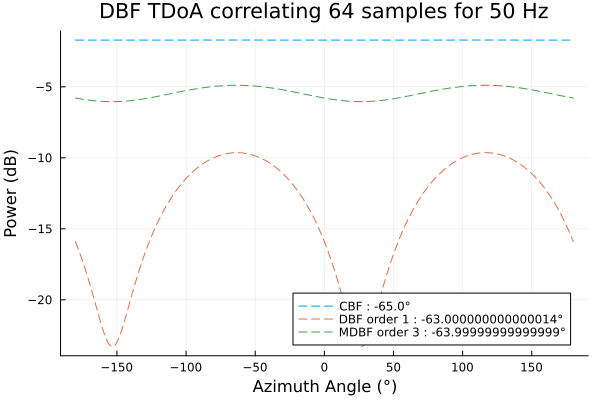

In [13]:
sam = 30;
p3 = plot(az, P_cbfs_db[:,sam], label="CBF : $(doas_cbfs[sam])°",
    linestyle=:dash);
plot!(az, P_dbfs_db[:,sam], label="DBF order $order : $(doas_dbfs[sam])°",
    linestyle=:dash);
plot!(az, P_mdbfs_db[:,sam], label="MDBF order $mdbf_order : $(doas_mdbfs[sam])°",
    linestyle=:dash);
xlabel!("Azimuth Angle (°)");
ylabel!("Power (dB)");
title!("DBF TDoA correlating $(corr_samples) samples for $(freq) Hz")
display(p3)

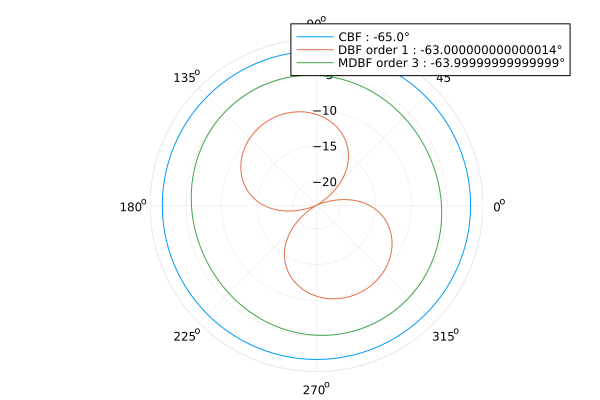

In [14]:
rmin = minimum([P_cbfs_db[:,sam] P_dbfs_db[:,sam]  P_dbfs_db[:, sam]]);
p4 = plot(deg2rad.(az), P_cbfs_db[:,sam],
            proj=:polar, label="CBF : $(doas_cbfs[sam])°",
    linestyle=:solid);
plot!(deg2rad.(az), P_dbfs_db[:,sam],
        proj=:polar, label="DBF order $order : $(doas_dbfs[sam])°",
    linestyle=:solid);
plot!(deg2rad.(az), P_mdbfs_db[:,sam],
        proj=:polar, label="MDBF order $mdbf_order : $(doas_mdbfs[sam])°",
    linestyle=:solid);
ylims!((rmin, 0))
# plot!(deg2rad.([90; 90]), [-30; 0], proj=:polar)
display(p4)